In [ ]:
# This Python 3 environment is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 


import os

# directories
#/kaggle/input/herbarium-2022-fgvc9/train_metadata.json
#/kaggle/input/herbarium-2022-fgvc9/sample_submission.csv
#/kaggle/input/herbarium-2022-fgvc9/test_metadata.json
#/kaggle/input/herbarium-2022-fgvc9/train_images/135/47/13547__018.jpg

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
#import random_split

## 1. Load metadata 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle competitions download -c herbarium-2022-fgvc9 --force

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 14% 20.1G/149G [01:56<17:00, 136MB/s]

In [ ]:

BASE_DIR = '/content/drive/My Drive'
#BASE_DIR = 

def get_dataframe(set_name):
  data_dirs = '{}/data'.format(BASE_DIR)
  dataset = []
  set_name.lower()
  if set_name == 'train':
    json_file = os.path.join(data_dirs, "train_metadata.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)   
    
    id_check = [] # Storing the image ids
    
    df_ann = pd.DataFrame(imgs_anns['annotations'])
    df_ann = df_ann[['image_id', 'category_id']]
    df_ann.set_index('image_id', inplace = True)

    df_images = pd.DataFrame(imgs_anns['images'])
    df_images = df_images[['image_id', 'file_name']]
    df_images.set_index('image_id', inplace = True)


  return df_ann.join(df_images, how = 'left')
#  return output_dataset

In [ ]:
train_prefix = 'train'
test_prefix = 'test'

In [ ]:
train_df = get_dataframe(train_prefix)
train_df=train_df
print(len(train_df))
train_df.head()

397


,category_id,file_name
image_id,,
00000__001,0,00000__001.jpg
00000__002,0,00000__002.jpg
00000__003,0,00000__003.jpg
00000__004,0,00000__004.jpg
00000__005,0,00000__005.jpg


In [ ]:
train_df.isna().sum()

category_id    0
file_name      0
dtype: int64

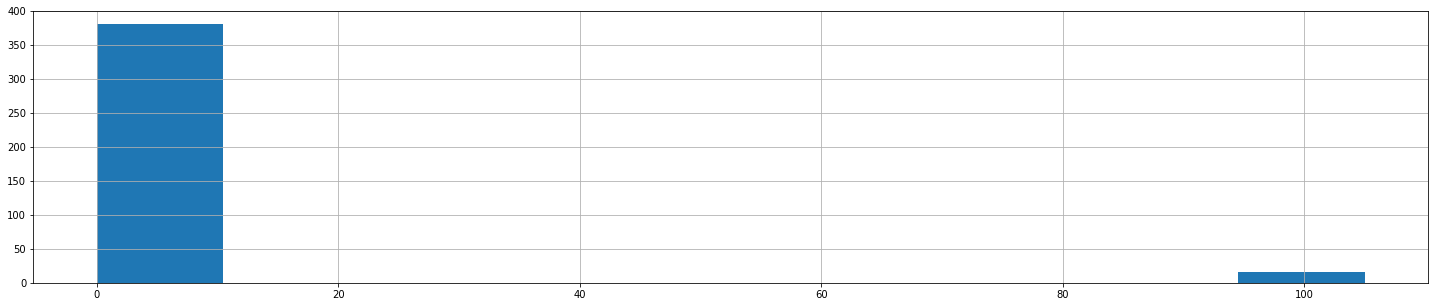

In [ ]:
train_df.category_id.hist(figsize = (25, 5))

In [ ]:
# how many examples of each class are presented in train dataset?
class_count = {target: len(train_df[train_df['category_id'] == target]) for target in sorted(train_df.category_id.unique())}
min(class_count.values()), max(class_count.values())

(16, 76)

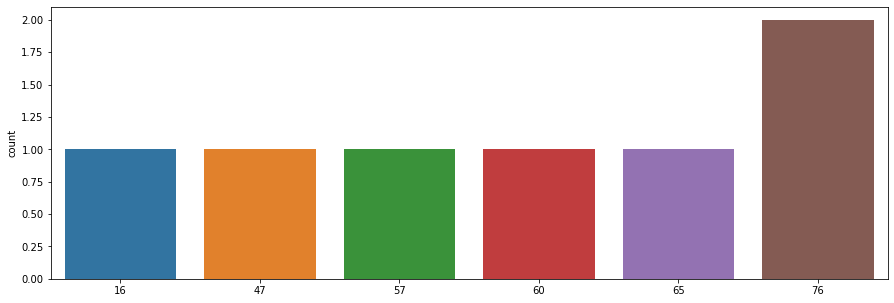

In [ ]:
import seaborn as sns

plt.figure(figsize = (15,5))
sns.countplot(x = list(class_count.values()))

In [ ]:
train_df = pd.concat([train_df[train_df['category_id'] == target] for target in class_count.keys()]).astype('str')
print(len(train_df))

397


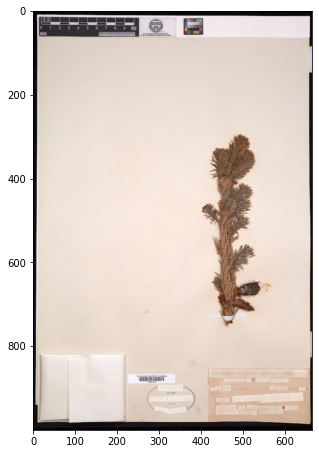

In [ ]:
import matplotlib.image as mpimg

data_dirs = '{}/data'.format(BASE_DIR)
image = mpimg.imread(os.path.join('{}/train'.format(data_dirs), train_df.iloc[0]['file_name']))

plt.figure(figsize = (5,10))
plt.imshow(image)
plt.show()

## 2. Download images

In [ ]:
# preprocess label value
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
train_df['category_id_encoded'] = le.fit_transform(train_df['category_id'])
train_df.head()

,category_id,file_name,category_id_encoded
image_id,,,
00000__001,0,00000__001.jpg,0
00000__002,0,00000__002.jpg,0
00000__003,0,00000__003.jpg,0
00000__004,0,00000__004.jpg,0
00000__005,0,00000__005.jpg,0


In [ ]:
# how many classes we have in the end?
num_of_classes = max(train_df['category_id_encoded']) + 1
num_of_classes

7

In [ ]:
# ImageDataGenerator().flow_from_dataframe(class_mode = 'sparse') requires string labels
train_df['category_id_encoded'] = train_df['category_id_encoded'].astype('str')
train_f = train_df.sample(frac = 1, replace=False, random_state=1)
train_df

,category_id,file_name,category_id_encoded
image_id,,,
00000__001,0,00000__001.jpg,0
00000__002,0,00000__002.jpg,0
00000__003,0,00000__003.jpg,0
00000__004,0,00000__004.jpg,0
00000__005,0,00000__005.jpg,0
...,...,...,...
00105__016,105,00105__016.jpg,2
00105__017,105,00105__017.jpg,2
00105__018,105,00105__018.jpg,2


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 120
train_datagen = ImageDataGenerator(rescale = 1/255.,
                                   validation_split = 0.25)


In [ ]:
!pip uninstall keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/Keras_Preprocessing-1.1.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/keras_preprocessing/*
Proceed (y/n)? y
  Successfully uninstalled Keras-Preprocessing-1.1.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-bd2lfwi3
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-bd2lfwi3
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-py3-none-any.whl size=43632 sha256=27bcb971d63b3852a916a48758bab41aef7b47171b22c0cd6ea8673cc7632c6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7dq89f2k/wheels/bf/e1/57/66a055d3b2d9df6aa39d4c92ae343808dd60cbb39dfdf7218f
Successfully built Keras-Preprocessing


In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = '{}/train'.format(data_dirs)
print(train_dir)

train_gen = train_datagen.flow_from_dataframe(dataframe = train_f,
                                              directory = train_dir,
                                              x_col = "file_name",
                                              y_col = "category_id_encoded",
                                              target_size=(img_size, img_size),
                                              batch_size = 8,
                                              class_mode = "sparse",
                                              subset = "training",
                                              shuffle=True
                                              )

val_gen = train_datagen.flow_from_dataframe(dataframe = train_f,
                                            directory = train_dir,
                                            x_col = "file_name",
                                            y_col = "category_id_encoded",
                                            target_size = (img_size, img_size),
                                            batch_size = 8,
                                            class_mode = 'sparse',
                                            subset = 'validation',
                                            shuffle=True
 )

/content/drive/My Drive/data/train
Found 297 validated image filenames belonging to 7 classes.
Found 98 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 2 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [ ]:
iimage=[]
llabel=[]
Iimage_i=[]
Liabel_i=[]
for i in range(33):
     iimage, llabel = train_gen.next()
     Iimage_i.append(iimage)
     Liabel_i.append(llabel)


In [ ]:
iimage=[]
llabel=[]
Vimage_i=[]
Viabel_i=[]
for i in range(11):
     iimage, llabel = val_gen.next()
     Vimage_i.append(iimage)
     Viabel_i.append(llabel)

In [ ]:
Viabel_i

[array([4., 5., 5., 5., 5., 5., 3., 1.], dtype=float32),
 array([5., 5., 5., 1., 4., 1., 4., 3.], dtype=float32),
 array([4., 5., 4., 5., 1., 5., 6., 4.], dtype=float32),
 array([2., 0., 1., 1., 1., 4., 3., 4.], dtype=float32),
 array([0., 5., 6., 6., 4., 5., 5., 1.], dtype=float32),
 array([5., 5., 0., 6., 3., 1., 3., 4.], dtype=float32),
 array([6., 1., 1., 1., 4., 0., 6., 2.], dtype=float32),
 array([6., 1., 4., 5., 5., 4., 1., 4.], dtype=float32),
 array([6., 2., 0., 6., 6., 0., 1., 2.], dtype=float32),
 array([4., 0., 6., 0., 0., 2., 4., 6.], dtype=float32),
 array([5., 6., 6., 5., 5., 6., 1., 1.], dtype=float32)]

## 3. Build a model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models, losses, Model

input_size = (img_size, img_size, 3) # all images are 120x120 size + RGB

input = Input(input_size)
#120x120
out = Conv2D(6, 5)(input)
out = MaxPooling2D()(out)
out = BatchNormalization()(out)
#116x116
#58x58
out = Conv2D(16,5)(out)
out = MaxPooling2D()(out)
out = BatchNormalization()(out)
#54x54
#27x27
out = Conv2D(120,5)(out)
out = MaxPooling2D()(out)
out = BatchNormalization()(out)
#23x23
#11x11
out = Conv2D(420,5)(out)
out = MaxPooling2D()(out)
out = BatchNormalization()(out)
#7x7
#3x3
out = Conv2D(1260,3)(out)
out = BatchNormalization()(out)
#1x1

out = Flatten()(out)
out = Dropout(0.3)(out)
out = Dense(num_of_classes)(out)
out = Dropout(0.3)(out)
out = Dense(num_of_classes,activation='tanh')(out)
model = Model(inputs = input, outputs = out)
opt = Adam(learning_rate = 0.003)


model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_55 (Conv2D)          (None, 116, 116, 6)       456       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 58, 58, 6)        0         
 g2D)                                                            
                                                                 
 batch_normalization_55 (Bat  (None, 58, 58, 6)        24        
 chNormalization)                                                
                                                                 
 conv2d_56 (Conv2D)          (None, 54, 54, 16)        2416      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 27, 27, 16)       0  

In [ ]:
history = model.fit(train_gen, epochs = 500, validation_data = val_gen)

Epoch 1/500
38/38 [==============================] - 7s 159ms/step - loss: 9.3899 - accuracy: 0.1380 - val_loss: nan - val_accuracy: 0.1020
Epoch 2/500
38/38 [==============================] - 5s 143ms/step - loss: 9.6052 - accuracy: 0.1279 - val_loss: nan - val_accuracy: 0.1020
Epoch 3/500
38/38 [==============================] - 5s 144ms/step - loss: 9.1508 - accuracy: 0.1111 - val_loss: nan - val_accuracy: 0.1020
Epoch 4/500
38/38 [==============================] - 5s 144ms/step - loss: 9.3101 - accuracy: 0.1616 - val_loss: nan - val_accuracy: 0.1020
Epoch 5/500
38/38 [==============================] - 5s 142ms/step - loss: 8.8203 - accuracy: 0.1414 - val_loss: nan - val_accuracy: 0.1020
Epoch 6/500
38/38 [==============================] - 6s 149ms/step - loss: 8.4495 - accuracy: 0.1751 - val_loss: nan - val_accuracy: 0.1020
Epoch 7/500
38/38 [==============================] - 6s 165ms/step - loss: 8.2906 - accuracy: 0.1549 - val_loss: nan - val_accuracy: 0.1020
Epoch 8/500
38/38 [=

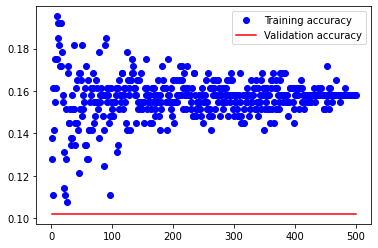

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation accuracy')
plt.legend()
plt.show()

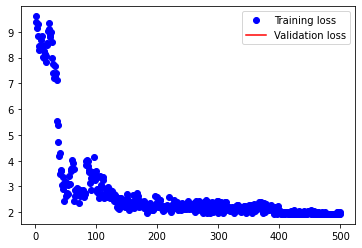

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()
plt.show()

In [ ]:
pred = []
y_true = []
for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    pred.extend([np.argmax(x) for x in model.predict(X_batch, verbose = 0)])
    y_true.extend(y_batch)
    
print(sum(np.array(pred) == np.array(y_true))/len(y_true))

0.10204081632653061


## 4. Predict

In [ ]:
images_dir = os.path.join('{}/train')
test_dir = images_dir.format(test_prefix)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, 
                                            directory = test_dir,
                                            x_col = "file_name",
                                            target_size = (img_size, img_size),
                                            batch_size = 32,
                                            class_mode = None,
                                            shuffle = False)

NameError: ignored

In [ ]:
pred = []
for i in range(len(test_gen)):
    pred.extend([np.argmax(x) for x in model.predict(test_gen[i], verbose = 0)])

In [ ]:
pred = le.inverse_transform(pred)

In [ ]:
sub = pd.read_csv(os.path.join(main_dir, 'sample_submission.csv'))
sub['Predicted'] = pred[:len(test_df)]
sub.head()

In [ ]:
sub.to_csv('submission.csv', index = False)  

In [ ]:
len(train_df)



397

In [ ]:
len(val_df)

NameError: ignored